# Optimizing variables over transition rate


In this notebook we are going to implement the method presented in Mouaffac etal. (J. Chem. Theory Comput. 2023, 19, 17, 5701–5711) on a simple 2D example.

In [1]:
import numpy as np
import folie as fl
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# Define model to simulate and type of simulator to use
dt = 1e-3

potential=fl.functions.MullerBrown()
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.asarray([0.5]) * np.eye(2, 2))
model_simu = fl.models.overdamped.Overdamped(force=potential, diffusion=diff_function)


(36, 36) (36, 36)


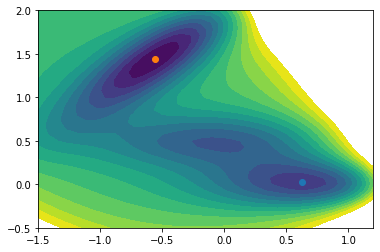

In [3]:
x = np.linspace(-1.5, 1.2, 36)
y = np.linspace(-0.5, 2.0, 36)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)

# Plot potential surface
pot = potential.potential_plot(X, Y)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))

# Also find the two minima of the potential

product = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[0.5, 0]).x.reshape(1,-1)  # minima one
reactant = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[-0.5, 1.5]).x.reshape(1,-1)  # minima two
ax.scatter(*product[0])
ax.scatter(*reactant[0])

Lets run some simulations of the model. We launch simulations from the transition state to obtain a full sampling of the transition.

In [37]:
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)

# initialize positions
ntraj = 30
q0 = np.empty(shape=[ntraj, 2])
for i in range(ntraj):
    q0[i,:] = [-0.90,0.500]

# Calculate Trajectory
time_steps = 20000
data = simulator.run(time_steps, q0, save_every=1)


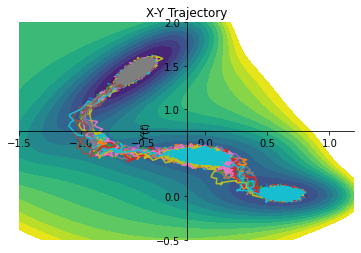

In [38]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
axs.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
for n, trj in enumerate(data):
    axs.plot(trj["x"][:, 0], trj["x"][:, 1])
    axs.spines["left"].set_position("center")
    axs.spines["right"].set_color("none")
    axs.spines["bottom"].set_position("center")
    axs.spines["top"].set_color("none")
    axs.xaxis.set_ticks_position("bottom")
    axs.yaxis.set_ticks_position("left")
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

Next step is to define a projection of the trajectories onto a 1d coordinate. We are using a simple linear combinaison followed by a sigmoid to constrain the result between 0 and 1.0 to define the projection.

[[0.26894142 0.27659226 0.28437609 ... 0.56779419 0.57723392 0.58661758]
 [0.27602094 0.283795   0.29169979 ... 0.57653652 0.58592456 0.59525058]
 [0.28321463 0.29110983 0.29913327 ... 0.5852312  0.59456203 0.60382504]
 ...
 [0.5445246  0.55407341 0.56358248 ... 0.8102182  0.81607827 0.8217972 ]
 [0.55336737 0.56287962 0.57234583 ... 0.81564904 0.8213784  0.82696747]
 [0.5621765  0.57164636 0.58106403 ... 0.82095882 0.82655825 0.83201839]]


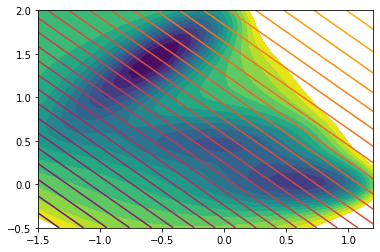

In [45]:
def projection(X,coefficient):
    return 1.0/(1+np.exp(-((1.0-coefficient)*X[:,0]+coefficient*X[:,1])))

# Show the initial cv
coefficient0 = 0.5
new_cv = projection(np.column_stack([X.ravel(),Y.ravel()]),coefficient0).reshape(X.shape)
print(new_cv)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

Let's now create the model

In [46]:
domain = fl.MeshedDomain.create_from_range(np.linspace(0,1, 10).ravel())
model_fit = fl.models.OverdampedSplines1D(domain=domain)

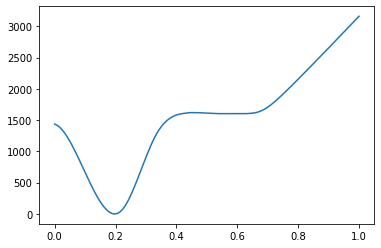

In [47]:

est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories(dt=dt)
for trj in data:
    data_proj.append(projection(trj["x"], coefficient0).reshape(-1,1))

est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(0.01,0.99,150))
plt.plot(np.linspace(0,1,150), pmf)

In [48]:
proj_product=projection(product, coefficient0)[0]
proj_reactant=projection(reactant, coefficient0)[0]
print(proj_reactant,proj_product)
mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[0.01,0.99], x_start=proj_reactant)
print(mfpt)

0.6086761950680056 0.5807294508811944
0.057957308143570946


In [49]:
def optimize_rate(params):
    data_proj = fl.Trajectories(dt=dt)
    for trj in data:
        data_proj.append(projection(trj["x"], params[0]).reshape(-1,1))
    est.fit(data_proj)
    proj_product=projection(product, params[0])[0]
    proj_reactant=projection(reactant, params[0])[0]
    mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[data_proj.stats.min[0],data_proj.stats.max[0]], x_start=proj_reactant)
    return -np.log(mfpt)

We can now run the optimisation

In [50]:
from scipy.optimize import minimize

# Get initial parameters
print(coefficient0)
res=minimize(optimize_rate, [coefficient0], method='Nelder-Mead', tol=1e-7)
print(res)

0.5
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.9377135234725107
             x: [ 6.871e-01]
           nit: 23
          nfev: 46
 final_simplex: (array([[ 6.871e-01],
                       [ 6.871e-01]]), array([-2.938e+00, -2.938e+00]))


In [53]:
from scipy.optimize import minimize_scalar
# We can also run simple 1D minimisation for comparaison
res=minimize_scalar(lambda c: optimize_rate([c]), bounds=(-1, 1), method='bounded')
print(res)

 message: Solution found.
 success: True
  status: 0
     fun: -14.656689340965094
       x: -0.4445446894434311
     nit: 13
    nfev: 13


In [54]:
print("Final MFPT",np.exp(-res.fun))

Final MFPT 2319099.0807594843


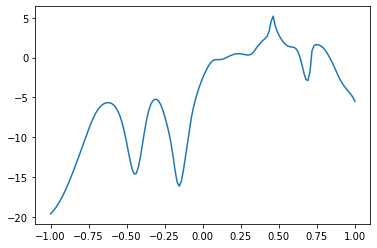

In [51]:
# Check minimization by plotting the objective function
c_range=np.linspace(-1,1.0, 150)
rate_vals = np.empty(c_range.shape[0])
for n,c in enumerate(c_range):
    rate_vals[n]=optimize_rate([c])
plt.plot(c_range,rate_vals)

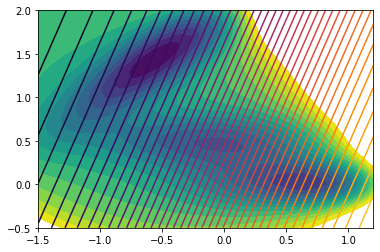

In [55]:
# Plot the new cv
new_cv = projection(np.column_stack([X.ravel(),Y.ravel()]), res.x).reshape(X.shape)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

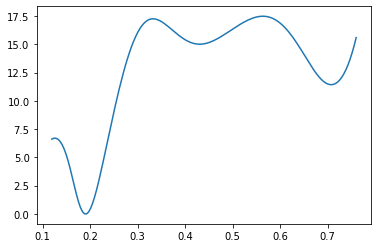

In [56]:
est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories(dt=dt)
for trj in data:
    data_proj.append(projection(trj["x"], res.x).reshape(-1,1))
est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(data_proj.stats.min[0],data_proj.stats.max[0],150))
plt.plot(np.linspace(data_proj.stats.min[0],data_proj.stats.max[0],150), pmf)

## Committor as optimal CV
For comparison, a computation of the committor can be done. The committor is the optimal variable.

count =  200 displacement =  0.009506987331661785
count =  400 displacement =  0.003167992046343782
count =  600 displacement =  0.020796912097614934
count =  800 displacement =  0.0035812493472359127
count =  1000 displacement =  0.0033247430049039763
count =  1200 displacement =  0.0027953119321168715
<meshio mesh object>
  Number of points: 4984
  Number of cells:
    triangle: 9687
<skfem MeshTri1 object>
  Number of elements: 9687
  Number of vertices: 4984
  Number of nodes: 4984
  Named subdomains [# elements]: reactant [0], product [0]


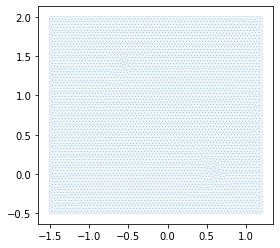

In [14]:
import skfem, meshio
import skfem.io
from folie.domains.distmesh import dellipse, drectangle,ddiff,dunion,distmesh2D,huniform
state_radius = 0.05

# Build 2D mesh
def dfunc(p):
    d0 = drectangle(p, -1.5, 1.2, -0.5, 2.0)
    dR = dellipse(p, reactant[0,0], reactant[0,1], state_radius, state_radius)
    dP = dellipse(p, product[0,0], product[0,1], state_radius, state_radius)
    d = ddiff(d0, dunion(dR, dP))
    return d
#pfix = np.array([[-1.5,-0.5 ],[-1.5,2.0],[1.2,-0.5],[1.2,2.0]])
#pts, tri = distmesh2D(dfunc, huniform, 0.04, [-1.5, 1.2, -0.5, 2.0], pfix)
pfix = np.empty((24,2))
pfix[:4,:] = np.array([[-1.51,-0.51 ],[-1.51,2.01],[1.21,-0.51],[1.21,2.01]])
for n,a in enumerate(np.linspace(0, 2*np.pi, 10, endpoint=False)):
    vec= np.array([np.cos(a), np.sin(a)])
    pfix[4+n,:] = reactant[0]+state_radius*vec
    pfix[14+n,:] = product[0]+state_radius*vec
    
pts, tri = distmesh2D(lambda p: drectangle(p, -1.51, 1.21, -0.51, 2.01), huniform, 0.04, [-1.51, 1.21, -0.51, 2.01], pfix)

mesh = meshio.Mesh(pts, [("triangle", tri)])
print(mesh)




In [34]:

def locate_R(x):
    return ((x - reactant.T) ** 2).sum(axis=0) < state_radius ** 2


def locate_P(x):
    return ((x - product.T) ** 2).sum(axis=0) < state_radius ** 2

# N_points = 50
# line_points_x = np.linspace(-1.5, 1.2, N_points)
# line_points_y = np.linspace(-0.5, 2.0, N_points)
# m = skfem.MeshTri().init_tensor(*(line_points_x, line_points_y))
m = skfem.io.from_meshio(mesh)
m = m.with_subdomains({"reactant": locate_R, "product": locate_P})
m = m.with_boundaries({"reactant": locate_R, "product": locate_P})
print(m)
e = skfem.ElementTriP2()

u_sol, states_fem, basis = fl.analysis.solve_committor_fem(model_simu, m, e, bc="domains")

<skfem MeshTri1 object>
  Number of elements: 9687
  Number of vertices: 4984
  Number of nodes: 4984
  Named subdomains [# elements]: reactant [14], product [14]
  Named boundaries [# facets]: reactant [0], product [0]


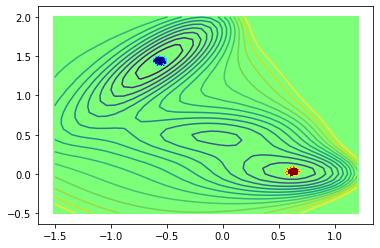

In [36]:
from skfem.visuals.matplotlib import plot, draw
fig = plt.figure()
ax = plt.axes()
plot(basis,states_fem, ax=ax)
ax.contour(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))

In [26]:
def apply_committor(X):
    return basis.probes(X.T) @ ((u_sol + 1) / 2)

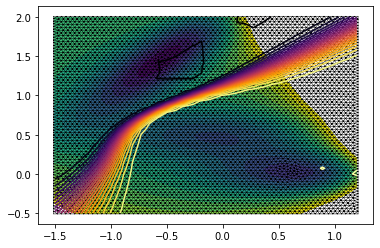

In [31]:
from skfem.visuals.matplotlib import plot, draw

fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
draw(m, ax=ax)
new_cv = apply_committor(np.column_stack([X.ravel(),Y.ravel()])).reshape(X.shape)


ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,25))


We can then explore the projected model on the optimal CV

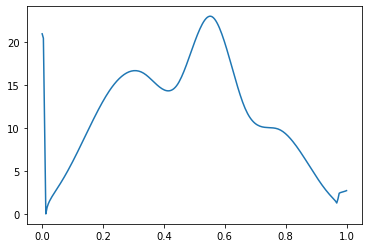

In [44]:
domain = fl.MeshedDomain.create_from_range(np.linspace(-1e-4,1+1e-4, 10).ravel())
model_committor = fl.models.OverdampedSplines1D(domain=domain)
projected_on_committor_data = fl.Trajectories(dt=dt)
for trj in data:
    projected_on_committor_data.append(apply_committor(trj["x"]).reshape(-1,1))

est=fl.KramersMoyalEstimator(model_committor)
est.fit(projected_on_committor_data)
pmf=fl.analysis.free_energy_profile_1d(model_committor, np.linspace(projected_on_committor_data.stats.min[0],projected_on_committor_data.stats.max[0],250))
plt.plot(np.linspace(0,1,250), pmf)

In [42]:
proj_product=apply_committor(product)[0]
proj_reactant=apply_committor(reactant)[0]
print(proj_reactant,proj_product)
mfpt = fl.analysis.mfpt_1d(model_committor,x_end=proj_product, x_range=[projected_on_committor_data.stats.min[0],projected_on_committor_data.stats.max[0]], x_start=proj_reactant)
print(mfpt)

0.0 0.9999999999999998
353310.5727507251
